# Simple OpenVINO Optimized YOLOv8 Inferencing Demo

### Load the previously prepared OpenVINO optimized YOLOv8 model

In [1]:
from openvino.runtime import Core
core = Core()

# Load the pre optimized model
yolov8n_with_preprocess_model_path = 'models/yolov8s_openvino_int8_model/yolov8s_with_preprocess.xml'
yolov8n_with_preprocess_model = core.read_model(yolov8n_with_preprocess_model_path)

import json
# Load the label map
with open('models/yolov8n_labels.json', 'r') as f:
    label_map = json.load(f)
    # convert str keys to int
    label_map = {int(k): v for k, v in label_map.items()}

### Setup the live player for inference

In [2]:
import collections
from IPython import display
import cv2
import numpy as np
import time
from datetime import datetime

# Init DeepSORT
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from utils import VideoPlayer, detect_without_preprocess, process_results, create_box_encoder, track_risk
from deepSORT import nn_matching
from deepSORT.tracker import Tracker
# from tools import generate_detections as gdet

# DeepSORT parameters and configurations
max_cosine_distance = 0.1
nn_budget = None
nms_max_overlap = 0.7
model_filename = 'deepSORT/model/mars-small128.pb'
encoder = create_box_encoder(model_filename, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric("cosine", max_cosine_distance, nn_budget)
tracker = Tracker(metric)
track_classes = ['person', 'backpack', 'handbag', 'suitcase']
baggage_classes = ['backpack', 'handbag', 'suitcase']
threat_classes = ['knife', 'scissors']
filter_classes = track_classes + threat_classes
pixel_density = 640
alert_config = {
    "unattended_bag": {
        "pixel_distance_percent": 0.6,
        "alert_duration": 20,
    },
    "threat": {
        "detection_confidence": 0.5,
        "alert_message": "Threat detected!"
    }
}
# store all configurations in a dict
deepsort_config = {
    'max_cosine_distance': max_cosine_distance,
    'nn_budget': nn_budget,
    'nms_max_overlap': nms_max_overlap,
    'model_filename': model_filename,
    'encoder': encoder,
    'metric': metric,
    'tracker': tracker,
    'track_classes': track_classes,
    'baggage_classes': baggage_classes,
    'threat_classes': threat_classes,
    'filter_classes': filter_classes,
    'alert_config': alert_config
}

# Run the object detection
def run_object_detection(source=0, flip=False, use_popup=False, skip_first_frames=0, model="None", device="None"):
    player = None
    # if device != "CPU":
    #     model.reshape({0: [1, 3, 640, 640]})
    compiled_model = core.compile_model(model, device)
    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(
            source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames
        )
        # Start capturing.
        player.start()
        if use_popup:
            title = "Detection and Alert (Press ESC to Exit)"
            cv2.namedWindow(
                winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE
            )

        processing_times = collections.deque()
        # relation history for unattended bag detection
        relation_history = {}
        alerts = collections.deque(maxlen=15)
        text_offset_y = 40  # Starting y position
        y_interval = 30     # Distance between each line of text
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results.
            input_image = np.array(frame)
           
            start_time = time.time()
            # model expects RGB image, while video capturing in BGR
            detections = detect_without_preprocess(input_image, compiled_model)[0]
            stop_time = time.time()

            frame, confident_tracks, extra_alert = process_results(results=detections, source_image=input_image, label_map=label_map, deepsort_config=deepsort_config)

            if extra_alert:
                for alert in extra_alert:
                    alerts.append(alert)

            # Parse tracker results and calculate risk
            frame, relation_history, alert = track_risk(frame=frame, deepsort_config=deepsort_config, confident_tracks=confident_tracks, relation_history=relation_history)

            _, f_width = frame.shape[:2]

            alert_img = np.zeros((frame.shape[0], f_width*2, 3), np.uint8) * 255
            if alert:
                alerts.append(alert)
            # Add alerts to the alerts image

            for idx, alert_text in enumerate(alerts):
                current_line = text_offset_y + idx * y_interval
                cv2.putText(
                    img=alert_img,
                    text=alert_text,
                    org=(20, current_line),  # Now each line will be drawn at a different location
                    fontFace=cv2.FONT_HERSHEY_COMPLEX,
                    fontScale=f_width / 1100,
                    color=(0, 0, 255),
                    thickness=1,
                    lineType=cv2.LINE_AA,
                )
           
            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )

            frame = np.hstack((frame, alert_img))
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Main frame
                _, encoded_img = cv2.imencode(
                    ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100]
                )
                i = display.Image(data=encoded_img)

                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

### Run the inference

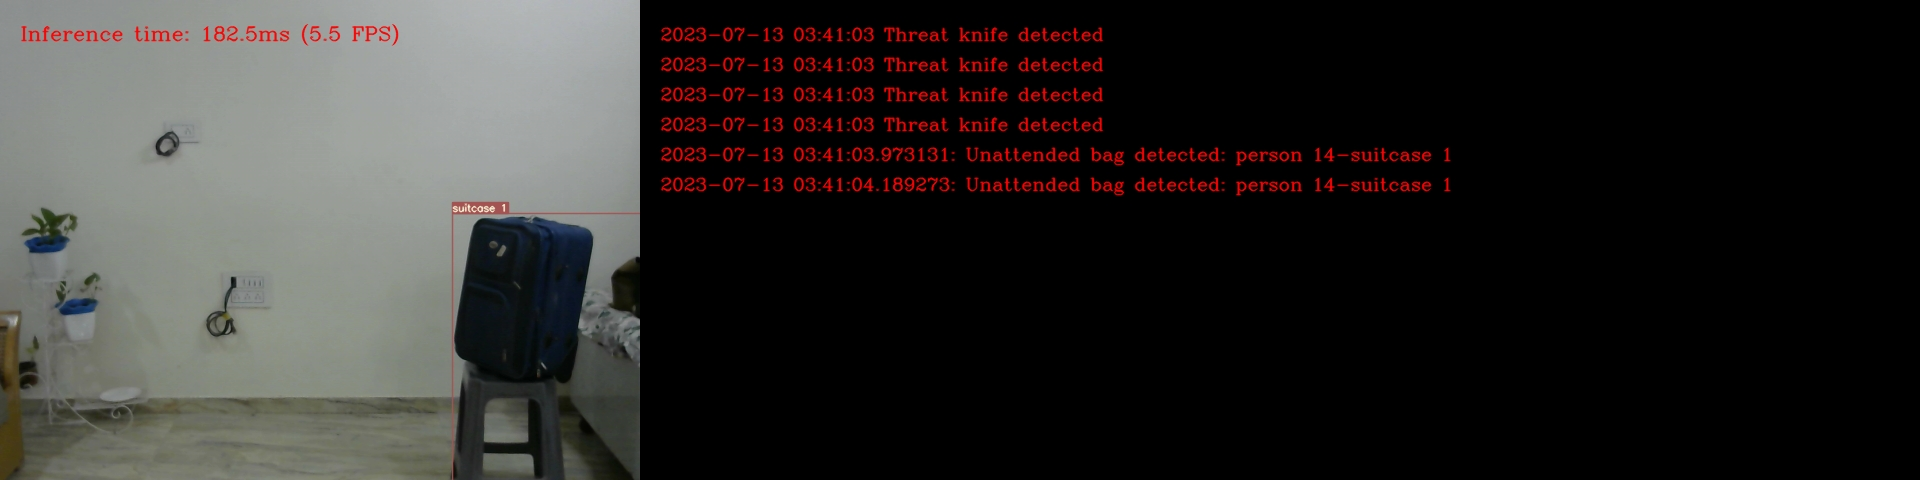

Interrupted


In [3]:
# Start the video feed and run the object detection
run_object_detection(source=0, flip=True, use_popup=False, model=yolov8n_with_preprocess_model, device="AUTO")